<a href="https://colab.research.google.com/github/allissonst/analise-netflix-daily-top-10/blob/main/Analise_Dados_Netflix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Informações sobre os dados de análise**
##Netflix Top 10 in the United States

#### Os dados analisados pertencem à base “Daily Netflix Top 10 Movie/TV Show in the United States”, pelo qual captura as obras com maior aparição no Top 10 da Netflix, considerando dados de 2020 a março de 2022. Os dados podem ser coletados no [Kaggle](https://www.kaggle.com/prasertk/netflix-daily-top-10-in-us). 

####Os dados foram coletados no dia 12/03/2022.


#### A base de dados comporta dez variáveis, sendo elas:  


✅ As of: Data de inicio considerada para a análise;

✅ Rank: posição da obra no ranking;

✅ Year to Date Rank: classificação do ano até a última data de análise;

✅ Last Week Rank: classificação da semana passada

✅ Title: título da obra;

✅ Type: tipo da obra;

✅ Netflix Exclusive: obra exclusiva da Netflix (sim/não);

✅ Netflix Release Date: data de lançamento da obra na Netfllix;

✅ Days In Top 10: total de dias em que este programa esteve no top 10;

✅ Viewership Score: uma pontuação atribuída a cada programa com base em sua classificação diária histórica, atribuindo 10 pontos para cada número.


In [164]:
#importando bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.weightstats import zconfint
import warnings

warnings.filterwarnings("ignore")

#lendo o dataframe da Netflix
netflix = pd.read_csv("netflix_daily_top_ten.csv")
print("tamanho do data base (linhas, colunas)", netflix.shape)

#renomeando colunas
netflix.rename(columns = {'As of':'as_of',
                          'Rank':'rank',
                          'Year to Date Rank':'year_to_date',
                          'Last Week Rank':'last_week_rank',
                          'Title':'title',
                          'Type':'type',
                          'Netflix Exclusive':'netflix_exclusive',
                          'Netflix Release Date':'netflix_release_date',
                          'Days In Top 10':'days_in_top_10',
                          'Viewership Score':'viewership_score'}, inplace = True)

#colocando o Not nos campos vazios representado o produto não exclusivo da Netflix
netflix['netflix_exclusive'] = netflix['netflix_exclusive'].fillna('Not')

netflix.head()



tamanho do data base (linhas, colunas) (7100, 10)


,as_of,rank,year_to_date,last_week_rank,title,type,netflix_exclusive,netflix_release_date,days_in_top_10,viewership_score
0,2020-04-01,1,1,1,"Tiger King: Murder, Mayhem …",TV Show,Yes,"Mar 20, 2020",9,90
1,2020-04-01,2,2,-,Ozark,TV Show,Yes,"Jul 21, 2017",5,45
2,2020-04-01,3,3,2,All American,TV Show,Not,"Mar 28, 2019",9,76
3,2020-04-01,4,4,-,Blood Father,Movie,Not,"Mar 26, 2020",5,30
4,2020-04-01,5,5,4,The Platform,Movie,Yes,"Mar 20, 2020",9,55


In [165]:
#deixando apenas os últimos registros dos produtos, pois os dados são acumulativos
netflix = netflix.drop_duplicates(
  subset = ['title'],
  keep = 'last').reset_index(drop = True)

In [166]:
#estatísticas descritivas
pd.set_option('display.float_format', lambda x: '%.2f' % x)
netflix.describe().round(2)[['days_in_top_10','viewership_score']]

,days_in_top_10,viewership_score
count,645.00,645.00
mean,11.18,61.75
std,19.99,97.75
min,1.00,1.00
25%,4.00,15.00
50%,7.00,33.00
75%,12.00,68.00
max,428.00,1474.00


Text(0.5, 1.0, 'Pontuação de audiência dos produtos hospedados na Netflix')

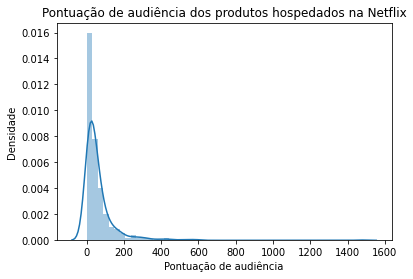

In [167]:
ax = sns.distplot(netflix.viewership_score)
ax.set(xlabel='Pontuação de audiência', ylabel='Densidade')
ax.set_title('Pontuação de audiência dos produtos hospedados na Netflix')

Text(0.5, 1.0, 'Pontuação de audiência dos produtos hospedados na Netflix')

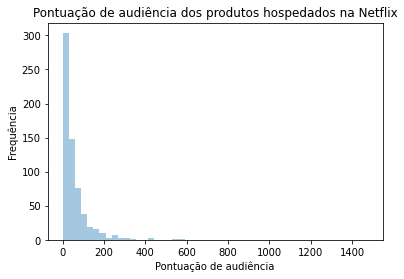

In [168]:
ax = sns.distplot(netflix.viewership_score, norm_hist= False, kde= False)
ax.set(xlabel='Pontuação de audiência', ylabel='Frequência')
ax.set_title('Pontuação de audiência dos produtos hospedados na Netflix')

Text(0.5, 1.0, 'Nota da pontuação de audiência de produtos hospedados na Netflix')

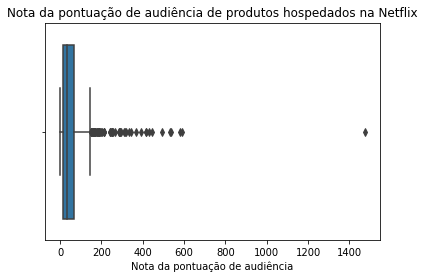

In [169]:
#mostrando o bloxpot
ax = sns.boxplot(netflix.viewership_score)
ax.set(xlabel='Nota da pontuação de audiência')
ax.set_title('Nota da pontuação de audiência de produtos hospedados na Netflix')

# Identificando e Removendo Outliers

In [170]:
valores = netflix["viewership_score"]
Q1 = valores.quantile(.25)
Q3 = valores.quantile(.75)
IIQ = Q3 - Q1
limite_inferior = Q1 - 1.5 * IIQ
limite_superior = Q3 + 1.5 * IIQ
limite_inferior

-64.5

In [171]:
netflix.query(f'viewership_score>={limite_inferior} and viewership_score<={limite_superior}').head()

,as_of,rank,year_to_date,last_week_rank,title,type,netflix_exclusive,netflix_release_date,days_in_top_10,viewership_score
0,2020-04-01,9,8,-,Badland,Movie,Not,"Mar 26, 2020",4,11
1,2020-04-01,10,9,-,Uncorked,Movie,Yes,"Mar 27, 2020",4,15
2,2020-04-02,9,5,4,The Platform,Movie,Yes,"Mar 20, 2020",10,57
3,2020-04-02,10,6,-,Car Masters: Rust to Riches,TV Show,Yes,"Sep 14, 2018",5,15
4,2020-04-03,9,-,-,Salt,Movie,Not,"Apr 1, 2020",1,2


In [172]:
netflix_sem_outliers = netflix.query(f'viewership_score>={limite_inferior} and viewership_score<={limite_superior}')
netflix_sem_outliers.describe()

,rank,days_in_top_10,viewership_score
count,585.00,585.00,585.00
mean,8.74,7.70,38.96
std,1.40,5.18,33.10
min,1.00,1.00,1.00
25%,8.00,4.00,13.00
50%,9.00,7.00,29.00
75%,10.00,10.00,58.00
max,10.00,34.00,145.00


Text(0.5, 1.0, 'Distribuição da pontuação de audiência de produtos hospedados na Netflix (- outliers)')

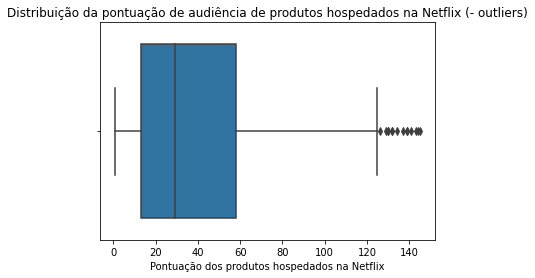

In [173]:
ax = sns.boxplot(netflix_sem_outliers.viewership_score)
ax.set(xlabel='Pontuação dos produtos hospedados na Netflix')
ax.set_title('Distribuição da pontuação de audiência de produtos hospedados na Netflix (- outliers)')

Text(0.5, 1.0, 'Distribuição da pontuação de audiência de produtos hospedados na Netflix (- outliers)')

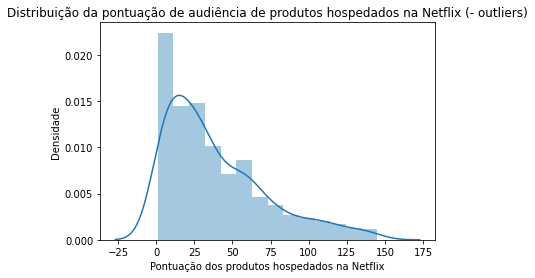

In [174]:
ax = sns.distplot(netflix_sem_outliers.viewership_score)
ax.set(xlabel='Pontuação dos produtos hospedados na Netflix', ylabel='Densidade')
ax.set_title('Distribuição da pontuação de audiência de produtos hospedados na Netflix (- outliers)')

**Analisando mais profundamente a pontuação dos produtos**

In [175]:
#analisando a média da pontuação por tipo de produto hospedado na Netflix
pontuacao_media_por_tipo = netflix.groupby("type").mean()["viewership_score"]
pontuacao_media_por_tipo

type
Concert/Perf…     15.00
Movie             39.51
Stand-Up Comedy   38.00
TV Show           90.31
Name: viewership_score, dtype: float64

In [176]:
#analisando a média da pontuação por produto exclusivo da Netflix (sim ou não)
pontuacao_media_por_exclusivo_netflix = netflix.groupby("netflix_exclusive").mean()["viewership_score"]
pontuacao_media_por_exclusivo_netflix 

netflix_exclusive
Not   49.04
Yes   69.09
Name: viewership_score, dtype: float64

# **Análise Cumulativa da pontuação do catálogo da Netflix**

Text(0.5, 1.0, 'Pontuação de audiência do catálogo da Netflix')

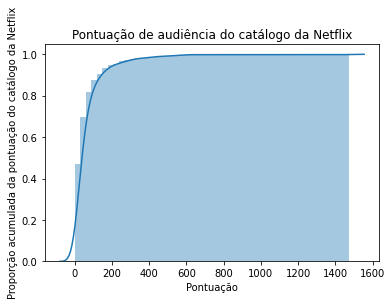

In [177]:
ax = sns.distplot(netflix.viewership_score, 
                  hist_kws = {'cumulative':True}, 
                  kde_kws = {'cumulative':True})
ax.set(xlabel='Pontuação', ylabel='Proporção acumulada da pontuação do catálogo da Netflix')
ax.set_title('Pontuação de audiência do catálogo da Netflix')

Text(0.5, 1.0, 'Pontuação de audiência (- outliers) do catálogo da Netflix')

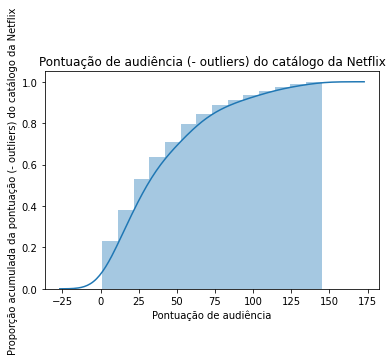

In [178]:
ax = sns.distplot(netflix_sem_outliers.viewership_score, 
                  hist_kws = {'cumulative':True}, 
                  kde_kws = {'cumulative':True})
ax.set(xlabel='Pontuação de audiência', ylabel='Proporção acumulada da pontuação (- outliers) do catálogo da Netflix')
ax.set_title('Pontuação de audiência (- outliers) do catálogo da Netflix')

# Analisando outros campos do df netflix

Text(0.5, 1.0, 'Quantidade de dias dos produtos Netflix em top 10')

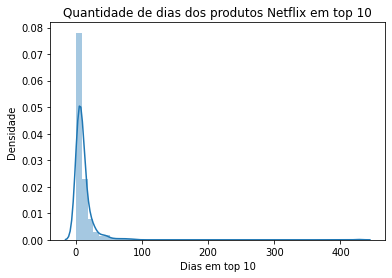

In [179]:
ax = sns.distplot(netflix.query("days_in_top_10 > 0").days_in_top_10)
ax.set(xlabel='Dias em top 10', ylabel='Densidade')
ax.set_title('Quantidade de dias dos produtos Netflix em top 10')

Text(0.5, 1.0, 'Quantidade de dias dos produtos Netflix (- outliers) em top 10')

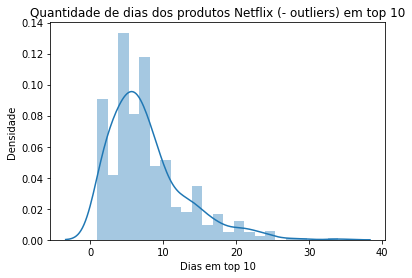

In [180]:
ax = sns.distplot(netflix_sem_outliers.query("days_in_top_10 > 0").days_in_top_10)
ax.set(xlabel='Dias em top 10', ylabel='Densidade')
ax.set_title('Quantidade de dias dos produtos Netflix (- outliers) em top 10')

In [181]:
print("Média da quantidade de vezes no ranking top 10:", round(netflix.viewership_score.mean()))

Média da quantidade de vezes no ranking top 10: 62


In [182]:
#Média da pontuação considerando [0:a inclusão de novas observações]
medias = list()
for i in range(1, len(netflix.viewership_score)):
    medias.append(netflix.viewership_score[0:i].mean())
medias

[11.0,
 13.0,
 27.666666666666668,
 24.5,
 20.0,
 22.666666666666668,
 20.0,
 19.375,
 19.22222222222222,
 20.2,
 18.636363636363637,
 21.333333333333332,
 19.846153846153847,
 19.5,
 20.0,
 19.125,
 21.647058823529413,
 21.333333333333332,
 23.05263157894737,
 24.45,
 23.38095238095238,
 23.545454545454547,
 22.652173913043477,
 23.166666666666668,
 22.6,
 22.423076923076923,
 21.88888888888889,
 23.464285714285715,
 25.103448275862068,
 24.366666666666667,
 24.387096774193548,
 24.46875,
 24.242424242424242,
 25.352941176470587,
 25.34285714285714,
 25.5,
 27.43243243243243,
 27.526315789473685,
 26.846153846153847,
 27.1,
 28.390243902439025,
 28.214285714285715,
 27.906976744186046,
 28.40909090909091,
 28.266666666666666,
 27.847826086956523,
 27.617021276595743,
 27.4375,
 27.755102040816325,
 29.26,
 29.372549019607842,
 29.346153846153847,
 32.16981132075472,
 32.851851851851855,
 32.527272727272724,
 32.142857142857146,
 31.94736842105263,
 31.93103448275862,
 31.4915254237288

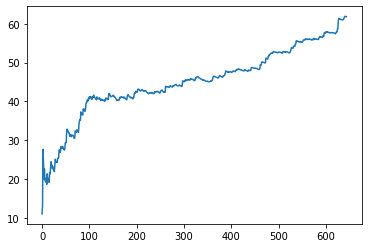

In [183]:
#Gráfico considerando a média da pontuação [de 0:inclusão de novas observações]

medias = list()
for i in range(1, len(netflix.viewership_score)):
    medias.append(netflix.viewership_score[0:i].mean())
plt.plot(medias)

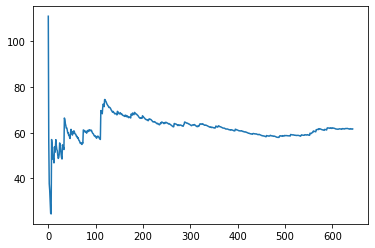

In [184]:
#Gráfico considerando a média da pontuação [de 0:inclusão de novas observações] puxando aleatoriamente os valores
np.random.seed(75243)
temp = netflix.viewership_score.sample(frac=1)

medias = list()
medias = [temp[0:i].mean() for i in range(1, len(temp))]

plt.plot(medias)

In [185]:
#intervalo de confiança para os valores da pontuação, considerando uma amostra grande
print(len(netflix))
zconfint(netflix.viewership_score)

645


(54.20696386220926, 69.29381133158918)

#**Vamos focar em analisar dois tipos agora:** 
##### 1 - TV Show (Séries)
##### 2 - Movie (Filmes)

In [186]:
pontuacao_tv_show = netflix.query('type == "TV Show"')
pontuacao_movie = netflix.query('type == "Movie"')

In [187]:
pontuacao_tv_show.head()

,as_of,rank,year_to_date,last_week_rank,title,type,netflix_exclusive,netflix_release_date,days_in_top_10,viewership_score
3,2020-04-02,10,6,-,Car Masters: Rust to Riches,TV Show,Yes,"Sep 14, 2018",5,15
7,2020-04-05,10,9,-,Unorthodox,TV Show,Yes,"Mar 26, 2020",6,15
9,2020-04-07,9,7,-,How to Fix a Drug Scandal,TV Show,Yes,"Apr 1, 2020",6,29
12,2020-04-12,10,-,-,Community,TV Show,Not,"Apr 1, 2020",2,2
13,2020-04-14,10,-,10,Legacies,TV Show,Not,"Apr 5, 2019",7,15


Text(0.5, 1.0, 'Pontuação de audiência para as séries')

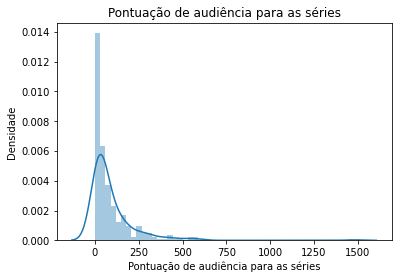

In [188]:
ax = sns.distplot(pontuacao_tv_show.viewership_score)
ax.set(xlabel='Pontuação de audiência para as séries', ylabel='Densidade')
ax.set_title('Pontuação de audiência para as séries')

Text(0.5, 1.0, 'Pontuação de audiência para as séries')

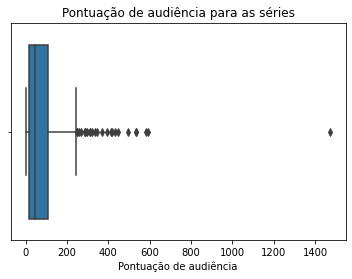

In [189]:
ax = sns.boxplot(pontuacao_tv_show.viewership_score)
ax.set(xlabel='Pontuação de audiência')
ax.set_title('Pontuação de audiência para as séries')

In [190]:
#intervalo de confiança para as séries
zconfint(pontuacao_tv_show.viewership_score)

(74.38259997547424, 106.24637528954342)

In [191]:
pontuacao_movie.head()

,as_of,rank,year_to_date,last_week_rank,title,type,netflix_exclusive,netflix_release_date,days_in_top_10,viewership_score
0,2020-04-01,9,8,-,Badland,Movie,Not,"Mar 26, 2020",4,11
1,2020-04-01,10,9,-,Uncorked,Movie,Yes,"Mar 27, 2020",4,15
2,2020-04-02,9,5,4,The Platform,Movie,Yes,"Mar 20, 2020",10,57
4,2020-04-03,9,-,-,Salt,Movie,Not,"Apr 1, 2020",1,2
5,2020-04-03,10,6,-,Blood Father,Movie,Not,"Mar 26, 2020",7,36


Text(0.5, 1.0, 'Pontuação de audiência para os filmes')

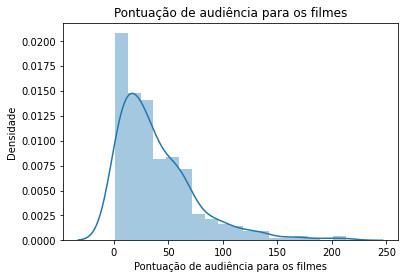

In [192]:
ax = sns.distplot(pontuacao_movie.viewership_score)
ax.set(xlabel='Pontuação de audiência para os filmes', ylabel='Densidade')
ax.set_title('Pontuação de audiência para os filmes')

Text(0.5, 1.0, 'Pontuação de audiência para os filmes')

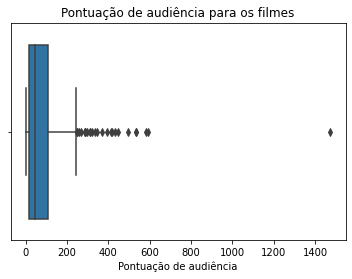

In [193]:
ax = sns.boxplot(pontuacao_tv_show.viewership_score)
ax.set(xlabel='Pontuação de audiência')
ax.set_title('Pontuação de audiência para os filmes')

In [194]:
#intervalo de confiança para as séries
zconfint(pontuacao_tv_show.viewership_score)

(74.38259997547424, 106.24637528954342)

#**Comparação de dois conjuntos da amostra**

In [195]:
print (ztest(pontuacao_tv_show.viewership_score, netflix.viewership_score))
zconfint(pontuacao_tv_show.viewership_score, netflix.viewership_score)
#A hipótese nula de que não há diferença na média é rejeitada

(3.606404583565531, 0.0003104689463261255)


(13.040437611344384, 44.087762459874824)

Text(0.5, 1.0, 'Distribuição das notas de acordo com os produtos')

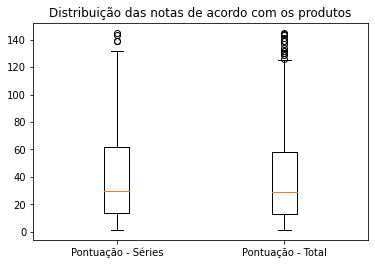

In [196]:
#plotando bloxpot para os dois tipos de produto Netflix (- outliers)
plt.boxplot([(pontuacao_tv_show.query(f'viewership_score>={limite_inferior} and viewership_score<={limite_superior}').viewership_score), (netflix.query(f'viewership_score>={limite_inferior} and viewership_score<={limite_superior}').viewership_score)], labels=["Pontuação - Séries", "Pontuação - Total"])
plt.title("Distribuição das notas de acordo com os produtos")

In [197]:
print (ztest(pontuacao_tv_show.viewership_score, pontuacao_movie.viewership_score))
zconfint(pontuacao_tv_show.viewership_score, pontuacao_movie.viewership_score)
#A hipótese nula de que não há diferença na média é rejeitada

(6.71327444052813, 1.90304700124484e-11)


(35.970044765390504, 65.63357838695109)

In [198]:
print(pontuacao_tv_show.viewership_score.mean())
print(pontuacao_movie.viewership_score.mean())
print(len(pontuacao_tv_show), len(pontuacao_movie))

90.31448763250883
39.51267605633803
283 355


Text(0.5, 1.0, 'Distribuição das notas de acordo com os produtos')

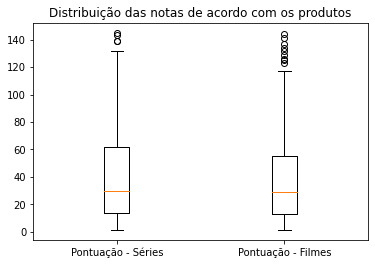

In [199]:
#plotando bloxpot para os dois tipos de produto Netflix (- outliers)
plt.boxplot([(pontuacao_tv_show.query(f'viewership_score>={limite_inferior} and viewership_score<={limite_superior}').viewership_score), (pontuacao_movie.query(f'viewership_score>={limite_inferior} and viewership_score<={limite_superior}').viewership_score)], labels=["Pontuação - Séries", "Pontuação - Filmes"])
plt.title("Distribuição das notas de acordo com os produtos")